In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve


In [2]:
enfermedades = pd.read_excel('archivos/CIE.xlsx')
new_df=  pd.read_csv ('archivos/NewDataAll.csv')

In [3]:
# Preprocesar los datos
new_df['Caudef']
enfermedades2 = enfermedades.copy()
enfermedades2.loc[enfermedades2['CAUSA'].str.len() == 3, 'CAUSA'] = enfermedades2.loc[enfermedades2['CAUSA'].str.len() == 3, 'CAUSA'] + "X"

new_df2 = pd.merge(new_df, enfermedades2, left_on='Caudef', right_on='CAUSA', how='left')
new_df2 = new_df2.dropna()
causas_infecciones = new_df2.loc[new_df2["DESCRIP"].str.contains("Infecciones|infecciones|infeccion|Infección|Infeccion|infección")]
causas_vih = new_df2.loc[new_df2["DESCRIP"].str.contains("VIH|vih|SIDA")]


In [4]:
# Filtrar las características y la variable objetivo
new_df2['VIH'] = 0
indices_vih = new_df2[new_df2['DESCRIP'].str.contains("VIH|vih|SIDA")].index
new_df2.loc[indices_vih, 'VIH'] = 1


In [5]:
new_df2.loc[new_df2["DESCRIP"].str.contains("VIH|vih|SIDA")]


,Unnamed: 0,Depreg,Mupreg,Mesreg,Añoreg,Depocu,Mupocu,Areag,Sexo,Diaocu,...,Nacdif,Dredif,Mredif,Caudef,Asist,Ocur,Cerdef,CAUSA,DESCRIP,VIH
448,448,1,101,11,9,1,101,1,1,13,...,0,1,101,B24X,1,1,1,B24X,Enfermedad por virus de la inmunodeficiencia h...,1
679,679,1,101,4,9,1,101,1,2,29,...,0,1,101,B207,1,1,1,B207,"Enfermedad por VIH, resultante en infecciones ...",1
705,705,1,101,3,9,1,101,1,1,28,...,0,1,101,B24X,1,1,1,B24X,Enfermedad por virus de la inmunodeficiencia h...,1
735,735,1,101,5,9,1,101,1,2,5,...,0,1,101,B200,1,1,1,B200,"Enfermedad por VIH, resultante en infección po...",1
845,845,1,101,6,9,1,101,1,1,31,...,0,1,101,B24X,1,1,1,B24X,Enfermedad por virus de la inmunodeficiencia h...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70970,70970,4,401,10,9,4,401,1,2,26,...,0,99,9999,B24X,1,1,2,B24X,Enfermedad por virus de la inmunodeficiencia h...,1
71597,71597,1,101,8,9,1,101,1,1,17,...,99,99,9999,B208,1,1,1,B208,"Enfermedad por VIH, resultante en otras enferm...",1
71625,71625,5,501,10,9,5,501,1,1,13,...,99,99,9999,B24X,1,1,1,B24X,Enfermedad por virus de la inmunodeficiencia h...,1
71628,71628,18,1801,5,9,18,1801,1,2,30,...,0,99,9999,B206,1,1,1,B206,"Enfermedad por VIH, resultante en neumonía por...",1


In [6]:
X = new_df2[['Añoreg']]
y = new_df2['VIH']

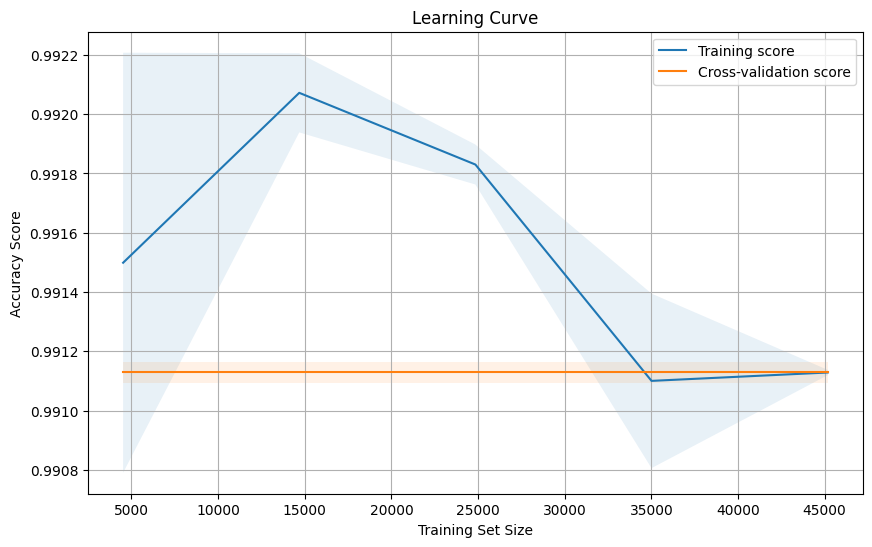

LogisticRegression()

In [7]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión logística
model = LogisticRegression()

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)

# Calcular las medias y desviaciones estándar de los puntajes
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')

# Rellenar la región entre ± una desviación estándar del puntaje de entrenamiento
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
# Rellenar la región entre ± una desviación estándar del puntaje de validación cruzada
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Entrenar el modelo
model.fit(X_train, y_train)



In [8]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)

# Calcular la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calcular la matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(confusion)

# Calcular la sensibilidad y especificidad
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir los resultados
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Matriz de Confusión:
[[13992     0]
 [  127     0]]
Accuracy: 0.991005028684751
Sensitivity: 0.0
Specificity: 1.0
